## Programming Assignment 4 - Building Ethical & Explainable AI

In this module, you will take on the role of an AI researcher at a technology startup tasked with developing a predictive tool for a financial institution. The client has identified that accurate income prediction could provide valuable insights for various business functions, such as identifying clients eligible for premium services or targeting financial assistance programs. However, it is essential that this tool is both ethical and interpretable, ensuring that decisions do not perpetuate societal biases or discriminate against individuals based on sensitive attributes.

### Objective:

Using the [Adult dataset](https://archive.ics.uci.edu/dataset/2/adult), you will develop a machine learning solution to predict whether an individual’s income is above or below $50K, based on features such as age, occupation, education, and hours worked. The model should not only achieve high accuracy in income prediction but also demonstrate transparency in its predictions and minimize any unfair biases related to sensitive attributes, including gender, race, and age.

### Overview of Tasks:

1. **Data Exploration and Preprocessing:** Start with a thorough exploratory data analysis (EDA) and basic dataset cleaning. Document your observations from the EDA, noting any patterns or potential biases.

2. **Model Development:** Using insights from previous assignments, build a Multi-Layer Perceptron (MLP) Classifier to predict income categories.

3. **Explainability Analysis:** Use the SHAP library to analyze feature importance and explain model predictions.

4. **Fairness Evaluation:** Assess the model using fairness metrics, including Statistical Parity Difference, Disparate Impact, and Equal Opportunity Difference. Evaluate model performance across various demographic groups, identifying any disparities or biases.

5. **Bias Mitigation:** Implement an in-processing bias mitigation technique (Adversarial Debiasing) to improve model fairness. Re-evaluate the model post-mitigation to assess both fairness improvements and predictive performance retention.

6. **Ethical Reflection:** Document your methodology, findings, and reflections. Provide an analysis of the ethical implications of your model’s predictions, especially in relation to sensitive demographic groups.

This notebook requires students to do some digging on their own; you will need to refer to cited research papers, library documentations and YouTube videos.

#### 1. Installing the required dependencies

We need to install the following dependencies inorder to run the notebook file. Make sure you create virtual environment using a dependency manager of your choice. Activate the virtual environment and then uncomment & run the following line of code. If you are unsure of the procedure to create a virtual environment, follow the steps provided in this [link](https://packaging.python.org/en/latest/guides/installing-using-pip-and-virtual-environments/).

In [1]:
!pip3 install scikit-learn pandas numpy matplotlib seaborn fairlearn ucimlrepo shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 9.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.1/31.1 MB 5.1 MB/s eta 0:00:0000:0100:01


We will also be using PyTorch for building Neural Networks. Follow the instructions given in the [official PyTorch documentation](https://pytorch.org/get-started/locally/) to install it in your machine based on your OS and architecture.

In [2]:
# PyTorch CPU is simpler to install across different OS and architecture and
# is more than sufficient for this question.

# For installing PyTorch CPU, you can simply uncomment and run the line below.

!pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu


In [3]:
# Importing the required libraries

import shap
import torch
import random
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo 
from typing import Dict, List, Tuple

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from fairlearn.adversarial import AdversarialFairnessClassifier

/Users/adrianhalgas/opt/anaconda3/envs/Lab1Jack/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Configuring the libraries for reproducibility

# Don't change the seed value
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

torch.use_deterministic_algorithms(True)

#### 2. Data Preprocessing & Feature Engineering

#### Dataset Description:

The Adult dataset, also known as the "Census Income" dataset, is a widely used dataset in the UCI Machine Learning Repository. It is primarily used for binary classification tasks, where the goal is to predict whether an individual's income exceeds $50K annually based on their demographic and employment information. The description of the various features present in the dataset is tabulated below.


| **Feature**         | **Type**               | **Description**                                                                                  |
|---------------------|------------------------|--------------------------------------------------------------------------------------------------|
| `age`               | Numerical              | The age of the individual.                                                                       |
| `workclass`         | Categorical            | The type of employer (e.g., Private, Self-emp, Government, etc.).                                |
| `fnlwgt`            | Numerical              | Final weight, representing the number of people the census believes this entry represents.       |
| `education`         | Categorical            | The highest level of education attained (e.g., Bachelors, HS-grad, etc.).                        |
| `education-num`     | Numerical              | The number of years of education.                                                                |
| `marital-status`    | Categorical            | Marital status (e.g., Married, Never-married, etc.).                                             |
| `occupation`        | Categorical            | The type of occupation (e.g., Tech-support, Sales, etc.).                                        |
| `relationship`      | Categorical            | Relationship to household head (e.g., Husband, Wife, Own-child, etc.).                           |
| `race`              | Categorical            | Race of the individual (e.g., White, Asian-Pac-Islander, Black, etc.).                           |
| `sex`               | Categorical            | Gender of the individual (e.g., Male, Female).                                                   |
| `capital-gain`      | Numerical              | Capital gains earned by the individual.                                                          |
| `capital-loss`      | Numerical              | Capital losses incurred by the individual.                                                       |
| `hours-per-week`    | Numerical              | The number of hours worked per week.                                                             |
| `native-country`    | Categorical            | Country of origin (e.g., United-States, Mexico, etc.).                                           |
| `income`            | Categorical (Label)    | Income class label (<=50K or >50K).                                                              |


In [5]:
# Fetching the Adult dataset from the UCI Machine Learning repository.
# Don't modify this code cell

adult = fetch_ucirepo(id=2) 
  
# data (as pandas dataframes) 
X = adult.data.features 
y = adult.data.targets  

df = pd.concat([X, y], axis=1)

del X, y

In [6]:
# Don't modify this code cell

df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K.
48838,64,NaN,321403,HS-grad,9,Widowed,NaN,Other-relative,Black,Male,0,0,40,United-States,<=50K.
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.


In [7]:
# Don't modify this code cell

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [24]:
# Don't modify this code cell

df_cleaned = df.copy()

**Remove the Null Values from the dataset.**  [Pandas Docs](https://pandas.pydata.org/docs/user_guide/index.html)

In [25]:
# Write your code here
df_cleaned = df_cleaned.dropna()

**Check if any of the categorical features has unknown categories and remove them.**

In [26]:
# Write your code here
print("Original DataFrame:")
print(df_cleaned)




Original DataFrame:
       age         workclass  fnlwgt  education  education-num  \
0       39         State-gov   77516  Bachelors             13   
1       50  Self-emp-not-inc   83311  Bachelors             13   
2       38           Private  215646    HS-grad              9   
3       53           Private  234721       11th              7   
4       28           Private  338409  Bachelors             13   
...    ...               ...     ...        ...            ...   
48836   33           Private  245211  Bachelors             13   
48837   39           Private  215419  Bachelors             13   
48839   38           Private  374983  Bachelors             13   
48840   44           Private   83891  Bachelors             13   
48841   35      Self-emp-inc  182148  Bachelors             13   

           marital-status         occupation   relationship  \
0           Never-married       Adm-clerical  Not-in-family   
1      Married-civ-spouse    Exec-managerial        Husband  

**Check if the dataset consists of duplicate values and remove them.**

In [28]:
# Write your code here
duplicate_rows = df_cleaned.duplicated()
print("Number of duplicate rows:", duplicate_rows.sum())

df_cleaned = df_cleaned.drop_duplicates()

Number of duplicate rows: 0


**The occupation feature has high cardinality. Let's group similar occupations together based on the given mapping.**

occupation
Skilled Labor              14975
Professional               12161
Administrative/Clerical     7021
Service                     6104
Sales                       5474
Unknown                     1843
Military                      14
Name: count, dtype: int64

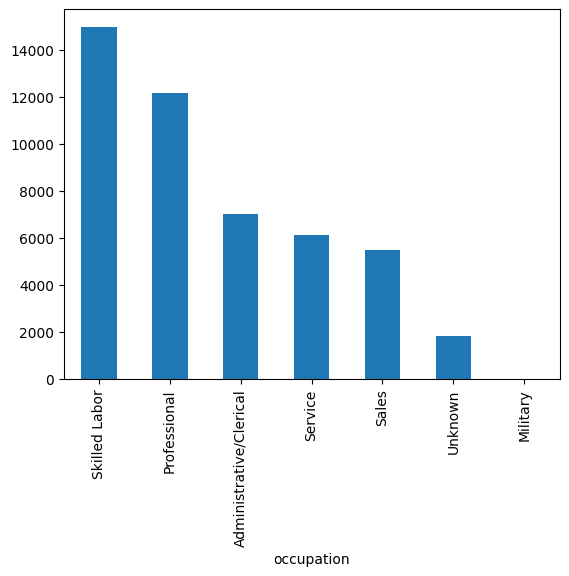

In [29]:
occupation_groups = {
    'Craft-repair': 'Skilled Labor',
    'Machine-op-inspct': 'Skilled Labor',
    'Farming-fishing': 'Skilled Labor',
    'Transport-moving': 'Skilled Labor',
    'Handlers-cleaners': 'Skilled Labor',
    
    'Prof-specialty': 'Professional',
    'Exec-managerial': 'Professional',
    
    'Adm-clerical': 'Administrative/Clerical',
    'Tech-support': 'Administrative/Clerical',
    
    'Sales': 'Sales',
    
    'Other-service': 'Service',
    'Protective-serv': 'Service',
    'Priv-house-serv': 'Service',
    
    'Armed-Forces': 'Military'
}

# Write your code here
df_cleaned['occupation'] = df_cleaned['occupation'].map(occupation_groups).fillna('Unknown')
df_cleaned['occupation'].value_counts().plot(kind='bar')

df_cleaned["occupation"].value_counts()

**Also group the education categories together based on the given mapping.**

education
High School Graduate             15437
Some College/Associate Degree    14102
Bachelor's Degree                 7876
High School (Incomplete)          4449
Graduate School                   4010
Middle School                      911
Primary School                     730
Preschool                           77
Name: count, dtype: int64

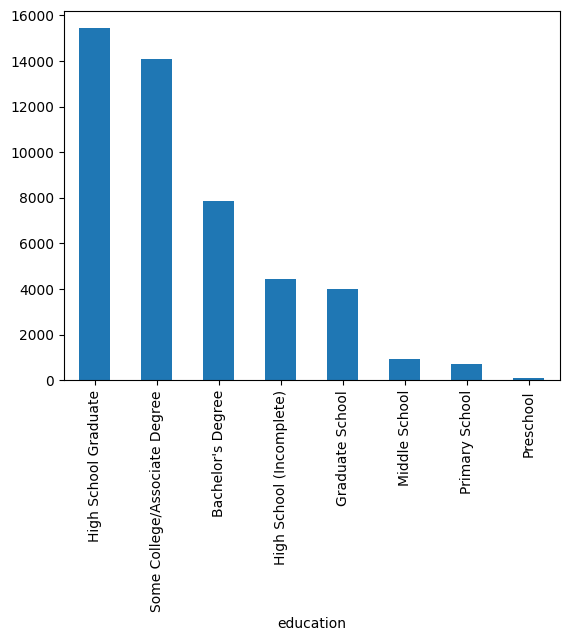

In [30]:
education_groups = {
    'Preschool': 'Preschool',
    '1st-4th': 'Primary School',
    '5th-6th': 'Primary School',
    '7th-8th': 'Middle School',
    '9th': 'High School (Incomplete)',
    '10th': 'High School (Incomplete)',
    '11th': 'High School (Incomplete)',
    '12th': 'High School (Incomplete)',
    'HS-grad': 'High School Graduate',
    'Some-college': 'Some College/Associate Degree',
    'Assoc-voc': 'Some College/Associate Degree',
    'Assoc-acdm': 'Some College/Associate Degree',
    'Bachelors': "Bachelor's Degree",
    'Masters': 'Graduate School',
    'Prof-school': 'Graduate School',
    'Doctorate': 'Graduate School'
}

# Write your code here
df_cleaned['education'] = df_cleaned['education'].map(education_groups).fillna('Unknown')
df_cleaned['education'].value_counts().plot(kind='bar')

df_cleaned["education"].value_counts()

**Group the similar workclass categories together based on the given mapping.**

workclass
Private Sector    33690
Government         6514
Self-employed      5524
Unknown            1843
Unpaid               21
Name: count, dtype: int64

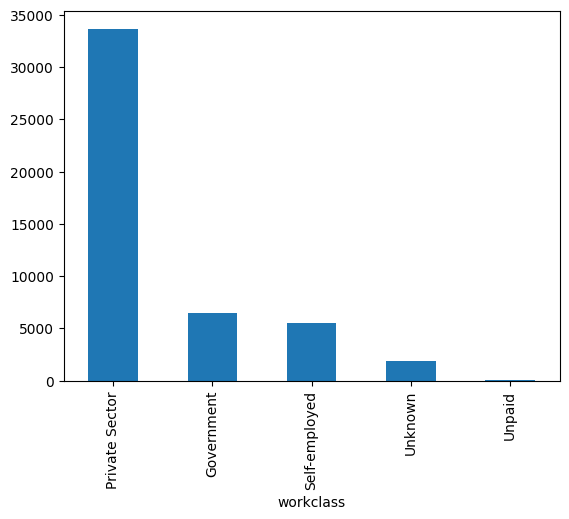

In [31]:
workclass_groups = {
    'Private': 'Private Sector',
    'Self-emp-not-inc': 'Self-employed',
    'Self-emp-inc': 'Self-employed',
    'Local-gov': 'Government',
    'State-gov': 'Government',
    'Federal-gov': 'Government',
    'Without-pay': 'Unpaid'
}

# Write your code here
df_cleaned['workclass'] = df_cleaned['workclass'].map(workclass_groups).fillna('Unknown')
df_cleaned['workclass'].value_counts().plot(kind='bar')

df_cleaned["workclass"].value_counts()

In [32]:
# Don't modify this code cell

df_cleaned['marital-status'] = df_cleaned['marital-status'].replace(
    {'Married-civ-spouse': 'Married', 'Married-spouse-absent': 'Married', 'Married-AF-spouse': 'Married'}
)

df_cleaned["marital-status"].value_counts()

marital-status
Married          22593
Never-married    15536
Divorced          6523
Separated         1497
Widowed           1443
Name: count, dtype: int64

In [33]:
# Don't modify this code cell

df_cleaned['race'] = df_cleaned['race'].replace({
    'Asian-Pac-Islander': 'Other',
    'Amer-Indian-Eskimo': 'Other'
})

df_cleaned["race"].value_counts()

race
White    40760
Black     4533
Other     2299
Name: count, dtype: int64

**Check if the target variable (income) is in the required format. If not preprocess it accordingly**

In [ ]:
# Write your code here

For the sake of simplicity, let's drop the `education-num`, `relationship`, `fnlwgt` and `native-country` columns.

**Write code for dropping the mentioned columns from the dataset.**

In [ ]:
# Write your code here

We observe that the dataset now includes 10 features and 1 target variable (`income`):

- `age`
- `workclass`
- `education`
- `marital-status`
- `occupation`
- `race`
- `sex`
- `capital-gain`
- `capital-loss`
- `hours-per-week`
- `income`

Suppose there exists an optimal model, $m^*$, which performs well in terms of both performance and fairness evaluation.

**Formulate a hypothesis about how the model $m^*$ should make predictions based on the input variables. Specifically, consider which variables the model should prioritize or weigh more heavily and which it might give less attention in our case.**

Write you answer here.

### Introduction to Sensitive Features and Bias in Machine Learning Models

In machine learning, **sensitive features** are attributes related to personal characteristics that should not be unfairly used to influence the predictions of a model. These features often include variables like **gender, race, age, disability status, or religion**. Because these attributes are closely tied to identity, they risk introducing **social biases** into machine learning models if not handled carefully. When sensitive features are present, models may inadvertently learn patterns that reinforce societal inequalities, resulting in unfair or discriminatory outcomes for certain groups.

#### Why Sensitive Features Introduce Bias

Sensitive features introduce bias because they are often correlated with target outcomes and other features in ways that reflect historical inequalities or discrimination. For example, race and income may be correlated because of systemic disparities in socioeconomic opportunities. Without careful handling, a machine learning model may inadvertently capture and amplify these correlations, leading to **disparate impacts** on different demographic groups. This can result in **unintended discrimination** where the model’s predictions favor one group over another.

#### Why Simply Removing Sensitive Features Doesn’t Eliminate Bias

It might seem like a straightforward solution to remove sensitive features from the dataset, under the assumption that this will make the model "blind" to these attributes. However, **removing sensitive features alone is insufficient** for achieving fairness, because:

1. **Indirect Correlations**: Other features, known as **proxy variables**, may carry information about sensitive attributes. For example, ZIP codes or education levels might be indirectly correlated with race or socioeconomic status.
2. **Data Imbalances**: The data itself may be imbalanced in terms of representation. Even without explicit sensitive features, models trained on biased data are likely to perform poorly for underrepresented groups.
3. **Historical Biases**: Sensitive attributes often reflect broader historical biases, so the outcomes themselves (e.g., income levels) are biased. Removing sensitive features without addressing these biases still leaves the model with skewed patterns learned from the data.

#### Strategies for Mitigating Bias in Machine Learning Models

Bias mitigation in machine learning involves applying specific techniques to ensure that model outcomes are fair across different demographic groups. Bias mitigation strategies can generally be divided into three categories:

1. **Pre-processing**: Transforming the data before training so that the sensitive attributes do not introduce unfair bias into the model. This can involve re-sampling, re-weighting, or modifying the dataset to balance representation across groups.
   
2. **In-processing**: Incorporating fairness constraints or adjustments into the model during training. For instance, **Adversarial Debiasing** is an in-processing technique that uses an adversarial component to reduce the influence of sensitive features on the predictions.

3. **Post-processing**: Adjusting the model’s predictions after training to ensure fairer outcomes. Post-processing can help align the model's results with fairness metrics, ensuring consistent performance across demographic groups.

Each of these strategies has its advantages and limitations, and often, a combination of these methods is required to achieve fair and unbiased outcomes.

For this module, we will be using the Adversarial Debiasing technique, which uses an adversarial network to debias the model.

**Based on your understanding of the problem statement, which of the attributes from our dataset could be sensistive variables? Provide reasoning.**

### 2. Exploratory Data Analysis

Let us visualize some of the sensitive attributes in the dataset and try to find interesting observations from the plots.

**Visualize the distribution of the sex feature across both the income categories. Write down your observations about the age feature from the visualization.**

In [ ]:
# Write your code here

Write you observations here

**Visualize the distribution of the marital status feature across both the income categories. Write down your observations about the marital status feature from the visualization.**

In [ ]:
# Write your code here

Write you observations here

**Visualize the distribution of the race feature across both the income categories. Write down your observations about the race feature from the visualization.**

In [ ]:
# Write your code here

Write you observations here

**Data Encoding for ML Models Training**

In [ ]:
# Machine Learning models requires the categorical features to be encoded
# in specific formats such as Ordinal or One-Hot encoded. The following line of
# code does Ordinal Encoding of the categorical column present in the dataset
# Check the utils file to see how the categories are encoded.

from utils import encode_df_for_ml_models

df_encoded = encode_df_for_ml_models(df_cleaned)

In [ ]:
income_label_encoding = {
    "<=50K": 0,
    ">50K": 1
}

df_encoded['income'] = df_encoded['income'].map(income_label_encoding)

df_encoded["income"].value_counts()

#### Introduction to Fairness Metrics in Machine Learning

Fairness metrics are designed to evaluate whether a machine learning model treats different demographic groups (e.g., based on gender, race, age) equitably in its predictions. These metrics are crucial for identifying and addressing any unintended biases that may result from training data or the model's learning process. Below are three commonly used fairness metrics that students will implement and analyze for their models:

##### Disparate Impact

The measure of disparate impact is formulated to represent the legal concept of "disparate impact." It ensures a balanced ratio between the positive prediction rates across different groups, meaning that the proportion of positive predictions should be consistent between groups. For instance, if a positive prediction corresponds to admission into a training program, this condition aims to ensure similar admission rates across groups. The measure is calculated as follows:

$$
\frac{P(\hat{Y} = 1 \mid S \neq 1)}{P(\hat{Y} = 1 \mid S = 1)} \geq 1 - \epsilon
$$

where $S$ is the protected attribute (such as race or gender), $S = 1$ represents the privileged group, and $S \neq 1$ denotes the unprivileged group. Here, $\hat{Y} = 1$ indicates a positive prediction. When $\hat{Y} = 1$ represents admission (e.g., to a training program), this condition seeks to ensure similar admission rates for both groups. A higher value for this measure implies more balanced rates between groups, indicating greater fairness. This concept aligns with the “80 percent rule” in disparate impact law, which mandates that the admission rate for any demographic group should be at least 80% of that of the group with the highest admission rate.

##### Demographic / Statistical parity

Demographic parity, also known as statistical parity, is similar to disparate impact, but instead of using a ratio, it evaluates the difference in positive prediction rates between groups. This measure ensures that the positive prediction rates are similar across groups. Formally, demographic parity is defined as:

$$
\left| P(\hat{Y} = 1 \mid S = 1) - P(\hat{Y} = 1 \mid S \neq 1) \right| \leq \epsilon
$$

where $S$ is the protected attribute (such as race or gender), $S = 1$ represents the privileged group, and $S \neq 1$ denotes the unprivileged group. A lower value of this measure implies more similar rates of positive predictions across groups, indicating greater fairness. Both demographic parity and disparate impact aim to assign positive predictions at similar rates for the two groups.

However, one limitation of these measures is that they may classify a highly accurate model as unfair if the base rates (the actual proportion of positive outcomes) differ significantly between groups. Additionally, to satisfy demographic parity, two similar individuals might receive different treatment based on group membership, which may be legally prohibited in some cases. This concept is also associated with affirmative action practices.

##### Equalized Odds

Equalized odds, a measure introduced by Hardt et al., aims to address the limitations of measures such as disparate impact and demographic parity. This measure evaluates fairness by comparing the false-positive rates (FPRs) and true-positive rates (TPRs) across groups, ensuring that both are similar between groups. Formally, equalized odds is defined by the following two conditions:

$$
\left| P(\hat{Y} = 1 \mid S = 1, Y = 0) - P(\hat{Y} = 1 \mid S \neq 1, Y = 0) \right| \leq \epsilon
$$

$$
\left| P(\hat{Y} = 1 \mid S = 1, Y = 1) - P(\hat{Y} = 1 \mid S \neq 1, Y = 1) \right| \leq \epsilon
$$

where the first condition requires the absolute difference in the FPRs of the two groups to be bounded by $ \epsilon $, and the second condition requires the absolute difference in the TPRs of the two groups to be similarly bounded. Smaller differences indicate better fairness.

Unlike demographic parity and disparate impact, an entirely accurate classifier will always satisfy the equalized odds criteria. However, equalized odds relies on the actual ground truth labels ($ Y $), which assumes that the base rates of the groups are representative and free from bias.

One notable use case demonstrating the effectiveness of this measure is the investigation of the COMPAS algorithm used in the U.S. criminal justice system. Although COMPAS had similar accuracy for both African-American and Caucasian groups when predicting recidivism, the odds differed. The algorithm falsely predicted future criminality (FPR) for African-Americans at twice the rate compared to Caucasians. Additionally, the algorithm significantly underestimated future crimes among Caucasians, resulting in a higher false-negative rate (FNR) for this group.

You can refer to this awesome Youtube Playlist on [Algorithmic Fairness](https://youtube.com/playlist?list=PLqDyyww9y-1Q0zWbng6vUOG1p3oReE2xS&si=fW59id6qAsIPwwOA) to understand the metrics and Algorithmic Fairness domain in more detail. 


**Implement the Demographic Parity and Equality Odds metrics in the FairnessMetrics class similar to the Disparate Impact metric based on the formulation provided above**

In [ ]:
class FairnessMetrics:
    def __init__(
        self, 
        df: pd.DataFrame, 
        sensitive_attribute: str, 
        pos_label: int, 
        true_label_col: str, 
        predicted_label_col: str, 
        privileged_groups: List[Dict[str, int]], 
        unprivileged_groups: List[Dict[str, int]]
    ):
        
        """
        Initialize the FairnessMetrics class with dataset and attribute information.

        Parameters:
        -----------
        df : pd.DataFrame
            The dataframe containing the labels, predictions, and sensitive attribute.
        
        sensitive_attribute : str
            The name of the sensitive attribute in the dataframe (e.g., race, gender).
        
        pos_label : int
            The integer value representing a positive outcome in both the label and prediction columns.
        
        true_label_col : str
            The name of the column representing the actual labels in the dataframe.
        
        predicted_label_col : str
            The name of the column representing the predicted labels in the dataframe.
        
        privileged_groups : List[Dict[str, int]]
            A list of dictionaries defining the privileged groups by attribute values.
        
        unprivileged_groups : List[Dict[str, int]]
            A list of dictionaries defining the unprivileged groups by attribute values.
        """
        
        self.df = df
        self.sensitive_attribute = sensitive_attribute
        self.pos_label = pos_label
        self.true_label_col = true_label_col
        self.predicted_label_col = predicted_label_col
        self.privileged_groups = privileged_groups
        self.unprivileged_groups = unprivileged_groups

    def compute_disparate_impact(self) -> float:
        """
        Compute the disparate impact, a measure of fairness, for a specified sensitive attribute
        based on positive prediction rates between privileged and unprivileged groups.
        """
        
        # Extract privileged and unprivileged categories
        privileged_categories = {group[self.sensitive_attribute] for group in self.privileged_groups}
        unprivileged_categories = {group[self.sensitive_attribute] for group in self.unprivileged_groups}
    
        # Filter DataFrames for privileged and unprivileged groups
        privileged_df = self.df[self.df[self.sensitive_attribute].isin(privileged_categories)]
        unprivileged_df = self.df[self.df[self.sensitive_attribute].isin(unprivileged_categories)]
        
        # Calculate positive prediction rates
        privileged_positive_rate = (
            privileged_df[privileged_df[self.predicted_label_col] == pos_label].shape[0] / privileged_df.shape[0]
        )
        unprivileged_positive_rate = (
            unprivileged_df[unprivileged_df[self.predicted_label_col] == pos_label].shape[0] / unprivileged_df.shape[0]
        )
    
        # Avoid division by zero
        if privileged_positive_rate == 0:
            self.disparate_impact = float('inf')  # Undefined disparate impact when privileged group has zero positive rate
            return
    
        # Compute disparate impact
        self.disparate_impact = unprivileged_positive_rate / privileged_positive_rate

    def compute_statistical_parity(self) -> float:
        """
        Compute the statistical parity (or demographic parity), a measure of fairness, for a specified
        sensitive attribute based on the difference in positive prediction rates between privileged and 
        unprivileged groups.
        """

        # Write your code here
        pass

    def compute_equalized_odds(self) -> Tuple[float, float]:
        """
        Compute the equalized odds, a fairness measure that ensures both the true positive rates (TPRs) 
        and false positive rates (FPRs) are similar between privileged and unprivileged groups for a 
        specified sensitive attribute.
        """

        # Write your code here
        pass


    def compute_metrics(self):
        self.compute_disparate_impact()
        self.compute_statistical_parity()
        self.compute_equalized_odds()

        print(f"Metadata:")
        print(f"True Label Column: {self.true_label_col}")
        print(f"Predicted Label Column: {self.predicted_label_col}")
        
        print()
        
        print("Fairness Metrics:")
        print(f"Disparate Impact: {self.disparate_impact:.3f}")
        print(f"Demographic / Statistical Parity: {self.statistical_parity:.3f}")
        print(f"Equalized Odds: TPR Difference = {self.tpr_difference:.3f}, FPR Difference: {self.fpr_difference:.3f}")
        print()

### 3. Train a PyTorch MLP model to predict the income

The predictor should take the features as input and output the probability of the income greater than 50K for that instance. Use BCELoss as the loss function. The model after the completion of training should have an accuracy score greater than 78%. Train the model on the training dataset `(X_train, y_train)` and evaluate the model's performance while training using the validation dataset `(X_test, y_test)`.

In [ ]:
# Don't modify this code cell

train, test = train_test_split(
    df_encoded, train_size=0.7, random_state=seed
)

In [ ]:
# Don't modify this code cell

X_train_df = train.drop(columns=["income"])
y_train_df = train["income"]

X_test_df = test.drop(columns=["income"])
y_test_df = test["income"]

In [ ]:
# Don't modify this code cell

X_train = X_train_df.values
y_train = y_train_df.values

X_test = X_test_df.values
y_test = y_test_df.values

In [ ]:
class MLPTabular(nn.Module):
    def __init__(self):
        super(MLPTabular, self).__init__()

        # Write your code here

    def forward(self, x):
        # Write your code here

        return x

In [ ]:
# Don't modify this code cell

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1) 
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
def train_model(model, criterion, optimizer, train_loader, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        # 1. Load the inputs and labels to the training device (CPU/GPU)
        # Write your code here

        # 2. Forward Pass and loss computation
        # Write your code here

        # 3. Backward Pass
        # Write your code here

        # Compute the loss and accuracy
        # Write your code here

    epoch_loss = running_loss / len(train_loader.dataset)
    accuracy = correct / total
    return epoch_loss, accuracy

def evaluate_model(model, criterion, val_loader, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            # 1. Load the inputs and labels to the training device (CPU/GPU)
            # Write your code here
    
            # 2. Forward Pass and loss computation
            # Write your code here

            # 3. Compute the validation loss and accuracy
            # Compute the loss and accuracy
    
    epoch_loss = running_loss / len(val_loader.dataset)
    accuracy = correct / total
    return epoch_loss, accuracy

In [ ]:
# Don't modify this code cell

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLPTabular().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
for epoch in range(1, num_epochs + 1):
    train_loss, train_accuracy = train_model(model, criterion, optimizer, train_loader, device)
    val_loss, val_accuracy = evaluate_model(model, criterion, val_loader, device)

    if (epoch % 2) == 0:
        print(f"Epoch [{epoch}/{num_epochs}] - "
              f"Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - "
              f"Val Loss: {val_loss:.4f} - Val Accuracy: {val_accuracy:.4f}")

In [ ]:
# Don't modify this code cell

model.eval()

with torch.no_grad():
    mlp_tabular_y_test_probs = model(X_test_tensor)

test["mlp_tabular_preds"] = np.where(mlp_tabular_y_test_probs >= 0.5, 1, 0)

In [ ]:
# Don't modify this code cell

mlp_clf_acc = accuracy_score(test["income"], test["mlp_tabular_preds"]) * 100
print(f"Accuracy of the MLP Classifier: {mlp_clf_acc:.2f}%")

**Computing the Fairness metrics using the MLP model predictions for the `sex` sensitive attribute.**

If we have a look at the value counts for the `sex` attribute. We can see that the Male category dominates the Female category. So, we hypothesize that the model would be biased towards the female category. The code cell below considers the male as the priviledged/dominant class and female as the unpriviledged class and finds the model bias using our fairness metric implementation.

In [ ]:
df_cleaned.sex.value_counts()

In [ ]:
sensitive_attribute = 'sex'

priviledged_groups = [{'sex': 0}]
unpriviledged_groups = [{'sex': 1}]

true_label_col = "income"
predicted_label_col = "mlp_tabular_preds"

pos_label = 1

metrics = FairnessMetrics(
    test, sensitive_attribute, pos_label, true_label_col, predicted_label_col,
    priviledged_groups, unpriviledged_groups
)

metrics.compute_metrics()

**Similar to the above code, find the priviledged and unpriviledged categories for the `race` variable and compute the Fairness metrics using the MLP model predictions.**

In [ ]:
# Write your code here

**Similar to the above code, find the priviledged and unpriviledged categories for the `marital-status` variable and compute the Fairness metrics using the MLP model predictions.**

In [ ]:
# Write your code here

### Introduction to Explainable AI (XAI)

**Explainable AI (XAI)** is a field focused on making the decisions of machine learning models understandable and interpretable to humans. As AI and machine learning models are increasingly used to make critical decisions—in fields such as healthcare, finance, and justice—it’s essential to understand how these models arrive at their predictions or recommendations. Explainability helps build trust in AI systems, allows for error identification, and ensures that models are making fair and unbiased decisions.

#### Why Linear and Tree-Based Models are Easier to Explain

1. **Linear Models**: 
   - Linear models, such as linear regression or logistic regression, are straightforward because their predictions are based on a weighted sum of input features.
   - The influence of each feature on the outcome can be easily understood by examining its weight: a positive weight indicates a positive influence, while a negative weight indicates a negative influence. This makes it easy to see which features drive the prediction and by how much.

2. **Tree-Based Models**: 
   - Decision Trees are also interpretable because they make predictions through a series of if-then rules.
   - Each decision node in the tree represents a split based on a feature, with branches leading to further splits or to leaf nodes (final predictions).
   - Since the path from root to leaf reveals the steps taken to arrive at a prediction, it’s easy to trace and understand the reasoning behind each decision. This transparency makes it straightforward to explain predictions in terms of the conditions set by each split.

These models are often considered **intrinsically interpretable** because their decision-making process aligns naturally with human reasoning.


#### Why Black-Box Models are Difficult to Explain

**Black-box models**, such as deep neural networks, ensemble models (like Random Forests), and support vector machines, are more complex and do not offer a straightforward interpretation of how individual features contribute to predictions. Here’s why they’re harder to explain:

1. **Complex Internal Structure**:
   - Black-box models can contain thousands or even millions of parameters that work together in complex ways to make predictions. For example, a deep neural network has multiple layers of interconnected neurons, each learning complex patterns from the data.
   - Unlike linear models, there isn’t a simple, direct relationship between input features and the prediction, making it challenging to understand why the model made a particular decision.

2. **Non-Linear Interactions**:
   - Black-box models often capture non-linear relationships, where interactions between features influence the prediction in ways that can’t be easily decomposed or traced.
   - In neural networks, for instance, inputs are transformed through a series of non-linear functions, and each layer adds more complexity, resulting in highly abstracted decision-making.

3. **Opaque Decision-Making**:
   - Black-box models don’t naturally reveal their decision-making processes. Unlike a decision tree that clearly shows the path taken to reach a decision, black-box models do not provide a clear, interpretable path from input to output.
   - This opacity makes it difficult to identify which features had the most influence on a given prediction or to validate the fairness of the model.


To make black-box models more interpretable, techniques like **SHAP (SHapley Additive exPlanations)** and **LIME (Local Interpretable Model-agnostic Explanations)** are used. These methods generate approximations of the model's behavior to provide insights into how different features contribute to individual predictions, but they do not offer the same level of transparency as linear or tree-based models.

In summary, while linear and tree-based models are inherently interpretable due to their straightforward structure, black-box models are challenging to explain because of their complexity and lack of transparency.


#### Shapley Values and the SHAP Python Library

For this module, we will use the SHAP python libary to explain the reasonle behind our MLP model's predictions.

Shapley values are a concept from cooperative game theory that provide a way to fairly distribute a payoff among players based on their contributions to the game. In the context of machine learning, Shapley values help us understand the contribution of each feature to a model’s predictions by treating each feature as a “player” in the game.

Shapley values calculate the average contribution of each feature by considering every possible combination of features. For each prediction, they indicate how much each feature adds to or subtracts from the model’s baseline prediction. This approach provides a consistent and unbiased measure of feature importance, allowing us to see which features are driving individual predictions.

Have you a look at this [Youtube Playlist](https://youtube.com/playlist?list=PLqDyyww9y-1SJgMw92x90qPYpHgahDLIK&si=--bNPcl3LCp2F25R) for learning about SHAP values in detail.

In [ ]:
# Don't modify this code cell

# Shap takes considerable amount of time to run. It's better to run the Explainer on a smaller subset of our dataset.

# `shap.kmeans` applies k-means clustering to the dataset to group data points into clusters based on their similarity.
# Instead of using every data point to estimate Shapley values, shap.kmeans selects a small number of representative samples 
# from these clusters, reducing computational costs while maintaining accuracy in the Shapley value estimates.

n_points = int(X_test.shape[0] * 0.01)
X_test_sampled = shap.kmeans(X_test, k=n_points)

# Instead of `shap.kmeans`, you can also randomly sample a subset of data points
# idx = np.arange(X_test.shape[0])
# random_idx = np.random.choice(idx, size=n_points)
# X_test_sampled = X_test[random_idx]

feature_names = test.columns.tolist()

**Use the GradientExplainer class from the Shap library to compute the feature importance of our MLP model.**

In [ ]:
# Write your code here

shap.summary_plot(shap_values, feature_names, plot_type="bar")

**Point out your observations from the above plot. What features does the model uses for making the prediction. Based on the computed fairness metrics, do you see any concerns regarding the rationale behind the model's ability to make predictions?**

### Adversarial Debiasing: A Method for Reducing Bias in Machine Learning Models

In this section, you will implement **Adversarial Debiasing** to create a fair machine learning model. This approach leverages an **adversarial network** to prevent a model from picking up on and acting upon unwanted biases related to sensitive attributes like gender or race.

### Adversarial Setup and Methodology

<div style="text-align: center;">
  <img src="./assets/adv_learning.png" alt="centered image" width="50%">
</div>

This figure illustrates the **architecture of the adversarial network**, a core component of the **Adversarial Debiasing** methodology. In this architecture, a **Predictor** model works to produce accurate predictions, while an **Adversary** model attempts to detect any biases related to sensitive attributes. The combination of these two models forms a system designed to mitigate bias and promote fairer predictions.

#### 1. Setting Up the Problem

In typical machine learning tasks, a model (called the **Predictor**) is trained to predict an outcome $Y$ from input data $X$. For example, $Y$ might be an income category prediction based on data such as age, education, and hours worked. However, training data often contains biases related to sensitive features like gender or race. If left unchecked, these biases can lead the model to make unfair predictions.

To mitigate this, **Adversarial Debiasing** introduces an additional model, called the **Adversary**, which works in opposition to the Predictor to identify and reduce the influence of sensitive features in the predictions.

#### 2. Building a Predictor and an Adversary

- **The Predictor**: This model’s goal is to predict the target outcome $\hat{y}$ (e.g., income level) as accurately as possible. The Predictor has weights $W$, which are optimized to minimize **prediction loss** $L_P(\hat{y}, y)$, where $y$ is the actual label.
  
- **The Adversary**: This model’s goal is to infer a protected attribute $\hat{z}$ (e.g., gender or race) from the Predictor’s output $\hat{y}$. The Adversary has weights $U$ and is trained to minimize **adversarial loss** $L_A(\hat{z}, z)$, where $z$ is the true sensitive attribute. By detecting the sensitive attribute, the Adversary reveals any indirect biases present in the Predictor’s output.

In essence, the Predictor attempts to produce accurate predictions while “hiding” any information about the sensitive attribute that the Adversary could use, making the output fairer and less biased.

#### 3. Training with Competing Objectives

During training:
- The Predictor is updated to make accurate predictions about the target while minimizing any hint of the sensitive attribute. This is achieved by training it to both:
  - Minimize prediction error (to be as accurate as possible).
  - Minimize the Adversary’s ability to detect the sensitive attribute (e.g., gender) from its predictions.
  
- The Adversary, in turn, is updated to detect the sensitive attribute as accurately as possible, despite the Predictor’s efforts to obscure it.

This dynamic creates a **“competition”** between the two models:
- The **Predictor** seeks to minimize the Adversary’s success by avoiding reliance on sensitive features.
- The **Adversary** strives to accurately detect the sensitive attribute, encouraging the Predictor to “hide” this information better.

This competition helps ensure that the Predictor learns to make accurate predictions without using sensitive information, thus promoting fairness.

#### 4. Achieving Fairness

By balancing the training objectives of the Predictor and Adversary, the final Predictor model learns to make accurate predictions without relying on the sensitive attribute. This results in **fairer** predictions, as the sensitive attribute no longer influences the outcome.

#### 5. Applying Fairness Metrics

To assess the effectiveness of adversarial debiasing, we apply various fairness metrics, including:
- **Demographic Parity**: Checks if positive prediction rates are similar across different groups.
- **Equalized Odds**: Ensures that both false-positive rates and true-positive rates are balanced across groups.

These metrics verify that the Predictor’s performance is consistent across different demographic groups and that adversarial training has effectively reduced bias.

By the end of this implementation, your model should demonstrate reduced bias while maintaining strong predictive performance, achieving a balance between accuracy and fairness.

Have a look at this [Youtube Video](https://youtu.be/37szRFkrmeQ?si=RMyBy-qJNHFoAI_F) to understand how Adversarial Debiasing works in more detail.

We'll implement AdversarialDebiasing using the Fairlearn package. Fairlearn is a libary that consists of pre-built fairness metrics and bias mitigation algorithms. References: [Ref 1](https://fairlearn.org/main/user_guide/mitigation/adversarial.html), [Ref 2](https://fairlearn.org/main/api_reference/generated/fairlearn.adversarial.AdversarialFairnessClassifier.html#fairlearn.adversarial.AdversarialFairnessClassifier), [Ref 3](https://fairlearn.org/main/auto_examples/plot_adversarial_basics.html#sphx-glr-auto-examples-plot-adversarial-basics-py), [Ref 4](https://fairlearn.org/main/auto_examples/plot_adversarial_fine_tuning.html#sphx-glr-auto-examples-plot-adversarial-fine-tuning-py)

**Create an MLP Adversary model for performing Adversarial Debiasing and optimize for demographic parity on the marital-status sensitive variable. The model after adversarial training should have an accuracy more than 75, the disparate impact should be more than 0.4, the statistical parity should be less than 0.2, the TPR and FPR difference should be less than 0.1**

Note: Check the documentation for the input and output shapes of the Adversary model. You may get incompatibility errors if you don't have them in the required size. Additionally, your model should also return logits instead of probability scores.

In [ ]:
class MLPAdversary(nn.Module):
    def __init__(self):
        super(MLPAdversary, self).__init__()
        # Write your code here

    def forward(self, x):
        # Write your code here

        return x

In [ ]:
predictor = MLPTabular()
adversary = MLPAdversary()

def optimizer_constructor(model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    return optimizer

# Complete the AdversarialFairnessClassifier class to train a fair classifier
adv_classifier = AdversarialFairnessClassifier(
    backend="torch",
    # Write your code here
    alpha=1,
    epochs=5,
    batch_size=32,
    random_state=seed
)

In [ ]:
# Don't modify this code cell

Z = 'marital-status'

Z_train = X_train_df[Z].values
Z_test = X_test_df[Z].values

In [ ]:
# Don't modify this code cell

adv_classifier.fit(X_train, y_train, sensitive_features=Z_train)

In [ ]:
# Don't modify this code cell

y_test_adv_clf = adv_classifier.predict(X_test)
test["adv_clf_preds"] = y_test_adv_clf

In [ ]:
# Don't modify this code cell

adv_clf_acc = accuracy_score(test["income"], test["adv_clf_preds"]) * 100
print(f"Accuracy of the Adversarial Classifier: {adv_clf_acc:.2f}")

In [ ]:
# Compute the fairness metrics for the adversarial classifier. Check if the metrics have improved

**Now that you have debiased the model using Adversarial Debiasing, can you check the features that are important for the model for making the predictions using the KernelExplainer from Shap. Does the model work similar to your initial hypothesis about an optimal model $m^*$?**

In [ ]:
# Write your code here

shap.summary_plot(shap_values, feature_names, plot_type="bar")

### References

1. UCI Machine Learning Repository: Adult Data Set. Available at: [https://archive.ics.uci.edu/dataset/2/adult](https://archive.ics.uci.edu/dataset/2/adult).

2. Pessach, D. and Shmueli, E., 2022. A review on fairness in machine learning. *ACM Computing Surveys (CSUR)*, 55(3), pp.1-44.

3. Xu, F., Uszkoreit, H., Du, Y., Fan, W., Zhao, D., & Zhu, J. (2019). Explainable AI: A Brief Survey on History, Research Areas, Approaches and Challenges. In *Natural Language Processing and Chinese Computing* (pp. 563-574). Springer International Publishing, Cham.

4. Zhang, B.H., Lemoine, B., and Mitchell, M., 2018, December. Mitigating unwanted biases with adversarial learning. In *Proceedings of the 2018 AAAI/ACM Conference on AI, Ethics, and Society* (pp. 335-340).

5. Kurakin, A., Goodfellow, I., and Bengio, S., 2016. Adversarial machine learning at scale. *arXiv preprint arXiv:1611.01236*.

6. PyTorch Documentation. Available at: [https://pytorch.org/docs/stable/index.html](https://pytorch.org/docs/stable/index.html).

7. SHAP (SHapley Additive exPlanations) Documentation. Available at: [https://shap.readthedocs.io/en/latest/](https://shap.readthedocs.io/en/latest/).

8. Achieving Algorithmic Fairness through Adversarial Training, Synapse 2022. Available at: [YouTube](https://www.youtube.com/watch?v=37szRFkrmeQ).

9. Algorithm Fairness, A Data Odyssey. Available at: [YouTube](https://www.youtube.com/playlist?list=PLqDyyww9y-1Q0zWbng6vUOG1p3oReE2xS).

10. SHAP Values, A Data Odyssey. Available at: [YouTube](https://www.youtube.com/playlist?list=PLqDyyww9y-1SJgMw92x90qPYpHgahDLIK).
